In [1]:
## Load R libraries.

inLibraries = list('repr',
                   'rgdal',
                   'gstat',
                   'spdep',
                   'rgeos',
                   'geoR',
                   'sp',
                   'RColorBrewer',
                   'classInt',
                   'MASS',
                   'forecast')

for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}

## Resize plot area.
options(repr.plot.width=15, repr.plot.height=15)

In [2]:
# Because ANOVA indicated a possible correlation between mass and lat/long, 
# that is where I am going with my analysis next.

In [3]:
train_ff <- read.csv('data/results/traintest/meteorite_falls_and_found_train.csv')
train_ff <- subset(train_ff, select = -c(X,X.1) )

test_ff <- read.csv('data/results/traintest/meteorite_falls_and_found_test.csv')
test_ff <- subset(test_ff, select = -c(X,X.1) )

head(train_ff)
head(test_ff)

,id,recclass,mass,fell_or_found,year,latitude,longitude,group,chondrite,type,lvl3,lvl4,lc_sample,weights
,<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,11632,L4,633.00,Found,1995,28.69167,13.21967,L,Chondrite,Stony,Ordinary,L,11,0.004857815
2,2320,L6,3200.00,Fell,1803,43.86667,5.38333,L,Chondrite,Stony,Ordinary,L,12,0.497990676
3,10154,H4,0.83,Found,1992,-30.73783,127.95367,H,Chondrite,Stony,Ordinary,H,11,0.004857815
4,11542,Eucrite-mmict,143.00,Found,1994,28.94550,13.06950,Eucrite,Achondrite,Stony,Asteroidal,H-E-D Vesta,11,0.004857815
5,11944,L6,23.60,Found,1991,-30.27467,129.01850,L,Chondrite,Stony,Ordinary,L,11,0.004857815
6,45918,LL6,425.00,Found,2006,20.01352,56.40697,LL,Chondrite,Stony,Ordinary,LL,11,0.004857815


,id,recclass,mass,fell_or_found,year,latitude,longitude,group,chondrite,type,lvl3,lvl4,lc_sample,weights
,<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,4,H5,331,Found,1982,26.80000,-105.41667,H,Chondrite,Stony,Ordinary,H,2,0.463225691
2,9,H4,4500,Found,1997,27.23944,29.83583,H,Chondrite,Stony,Ordinary,H,11,0.004857815
3,12,H5,228,Found,1989,27.61667,3.85000,H,Chondrite,Stony,Ordinary,H,14,0.498018660
4,13,H5,145,Found,1989,27.81667,4.03333,H,Chondrite,Stony,Ordinary,H,14,0.498018660
5,16,H3.9/4,561,Found,1989,27.63333,3.96667,H,Chondrite,Stony,Ordinary,H,14,0.498018660
6,17,L5,542,Found,1989,27.51667,3.65000,L,Chondrite,Stony,Ordinary,L,14,0.498018660


In [4]:
coordinates(train_ff)<-~longitude+latitude
proj4string(train_ff)<- CRS("+proj=aeqd +lon_0=0 +lat_0=0 +datum=WGS84 +units=m +no_defs")

In [5]:
coordinates(test_ff)<-~longitude+latitude
proj4string(test_ff)<- CRS("+proj=aeqd +lon_0=0 +lat_0=0 +datum=WGS84 +units=m +no_defs")

Warning message in classIntervals(inVa, numcat, style = "kmeans", rtimes = repeattimes):
“N is large, and some styles will run very slowly; sampling imposed”


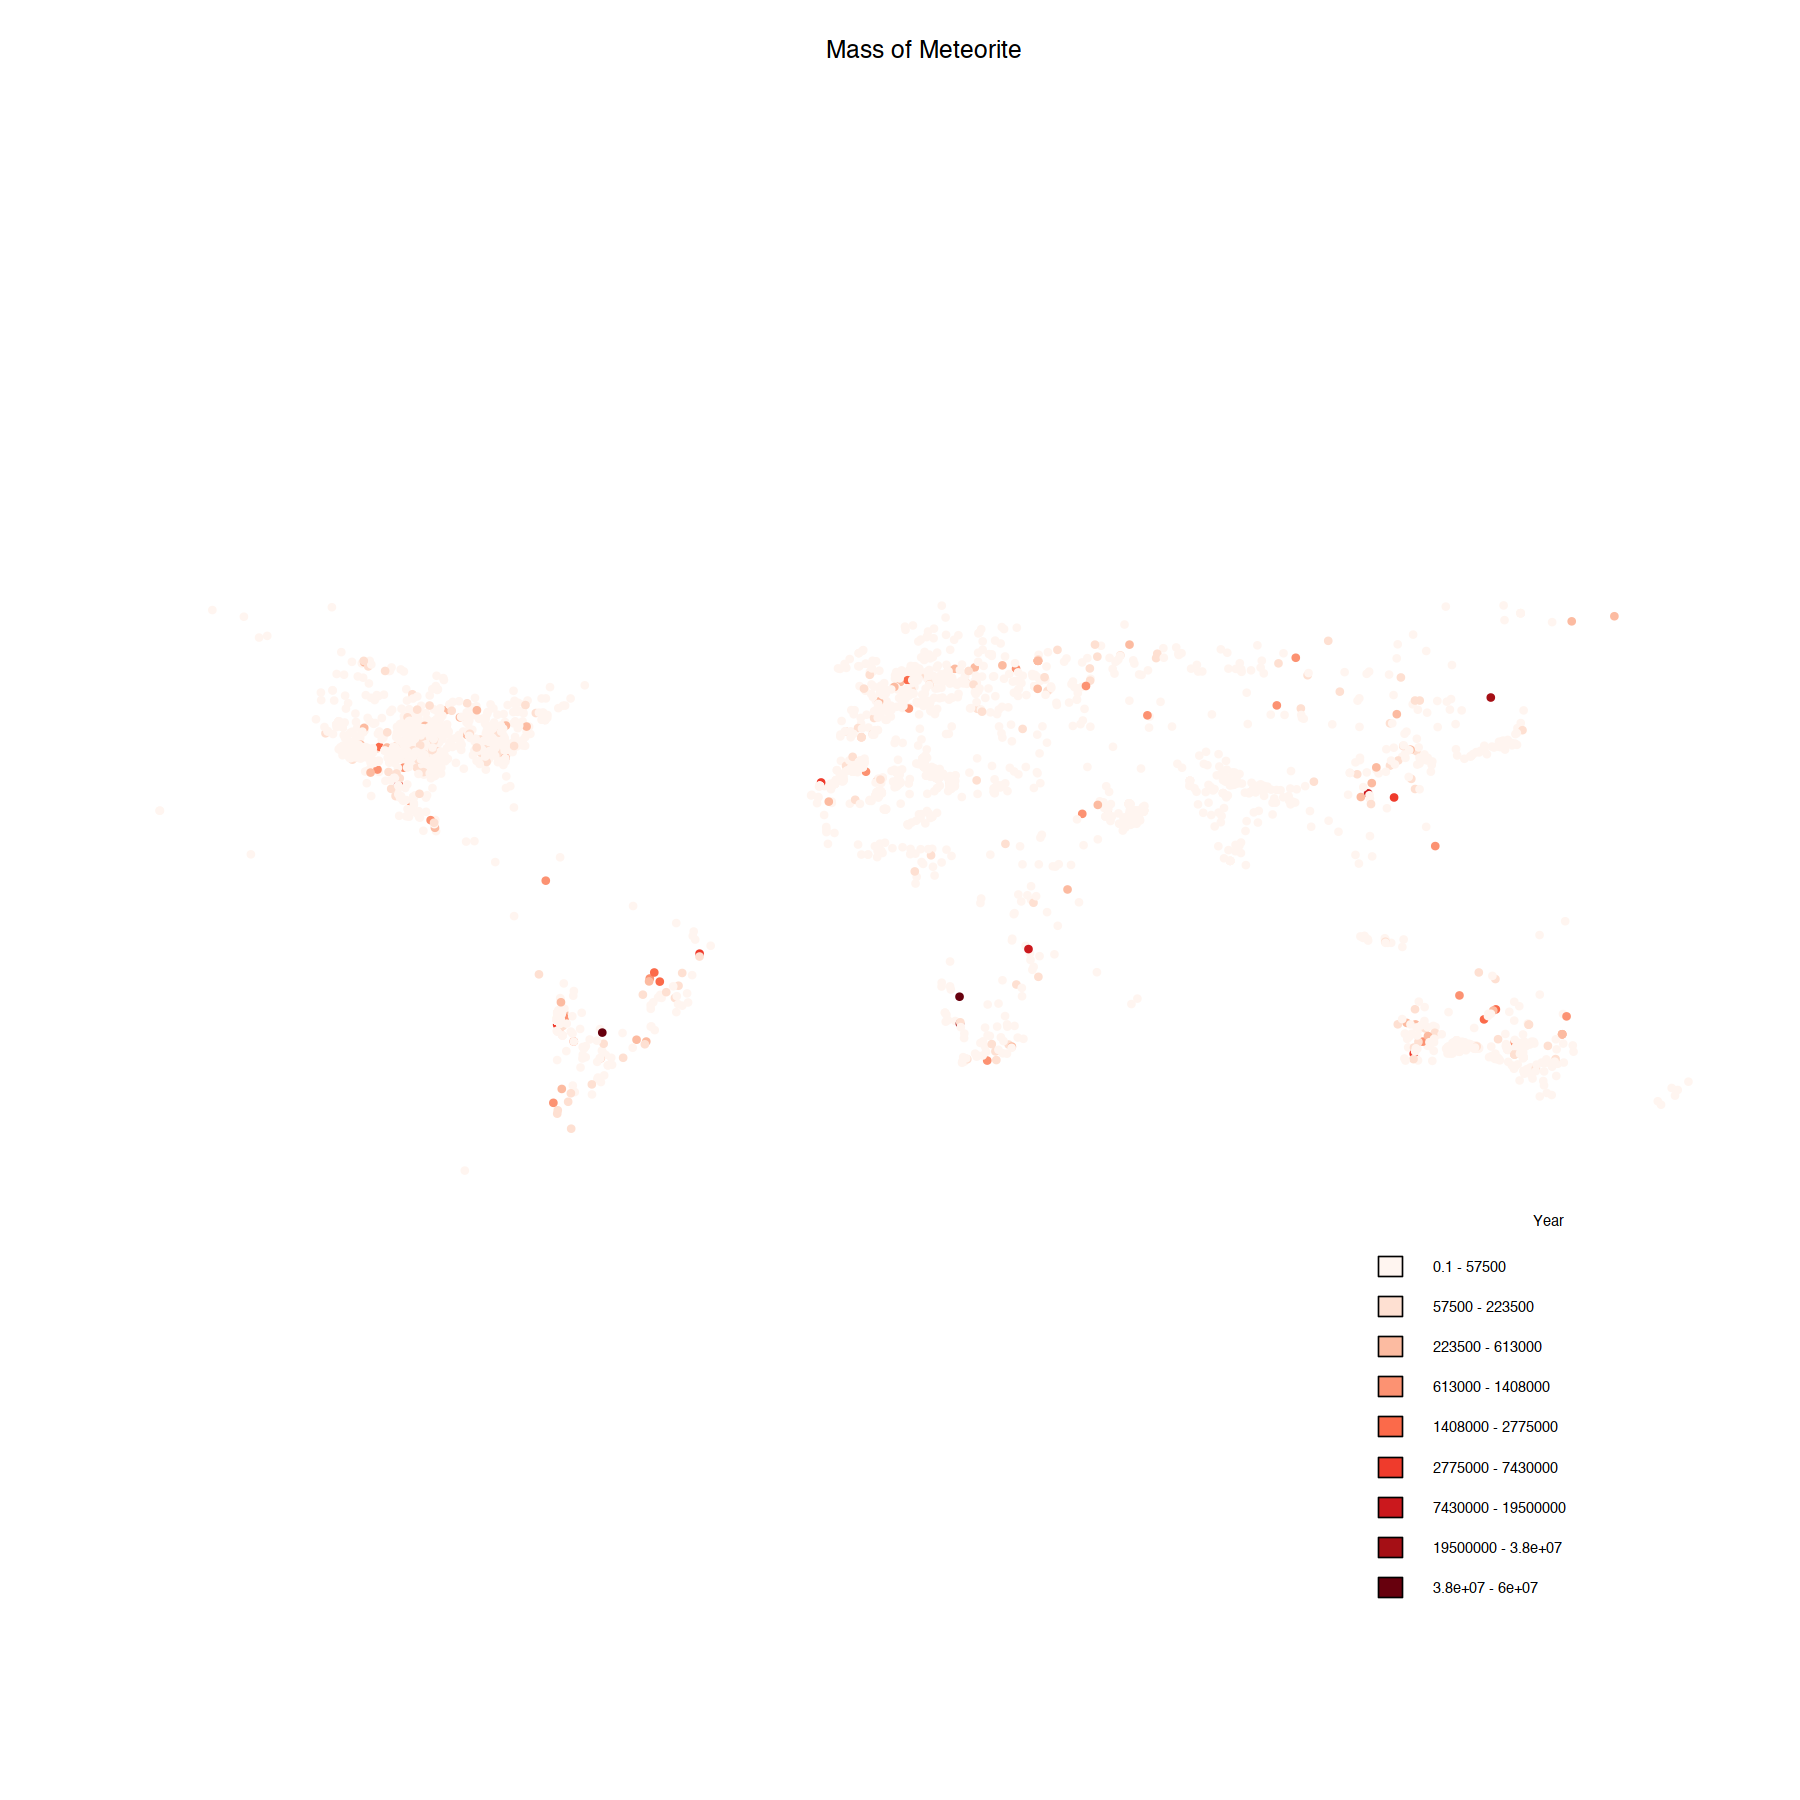

In [6]:
#Defining variable for study

inVa <- as.numeric (train_ff$mass)

## Configure classification parameters.

numcat <- 9
repeattimes <- 25
cate <- classIntervals(inVa, numcat, style="kmeans",rtimes=repeattimes)

## Assign colors to categories.

pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

## Map input data.

plot(train_ff, col=cols, pch=20, main="Mass of Meteorite")

## Map classification scheme.

decimalPlaces <- 3
brks.dec <- round(cate$brks,decimalPlaces)
leg.text <- paste(brks.dec[-(numcat+1)], brks.dec[-1], sep=" - ")
legend("bottomright",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Year",cex=.7)

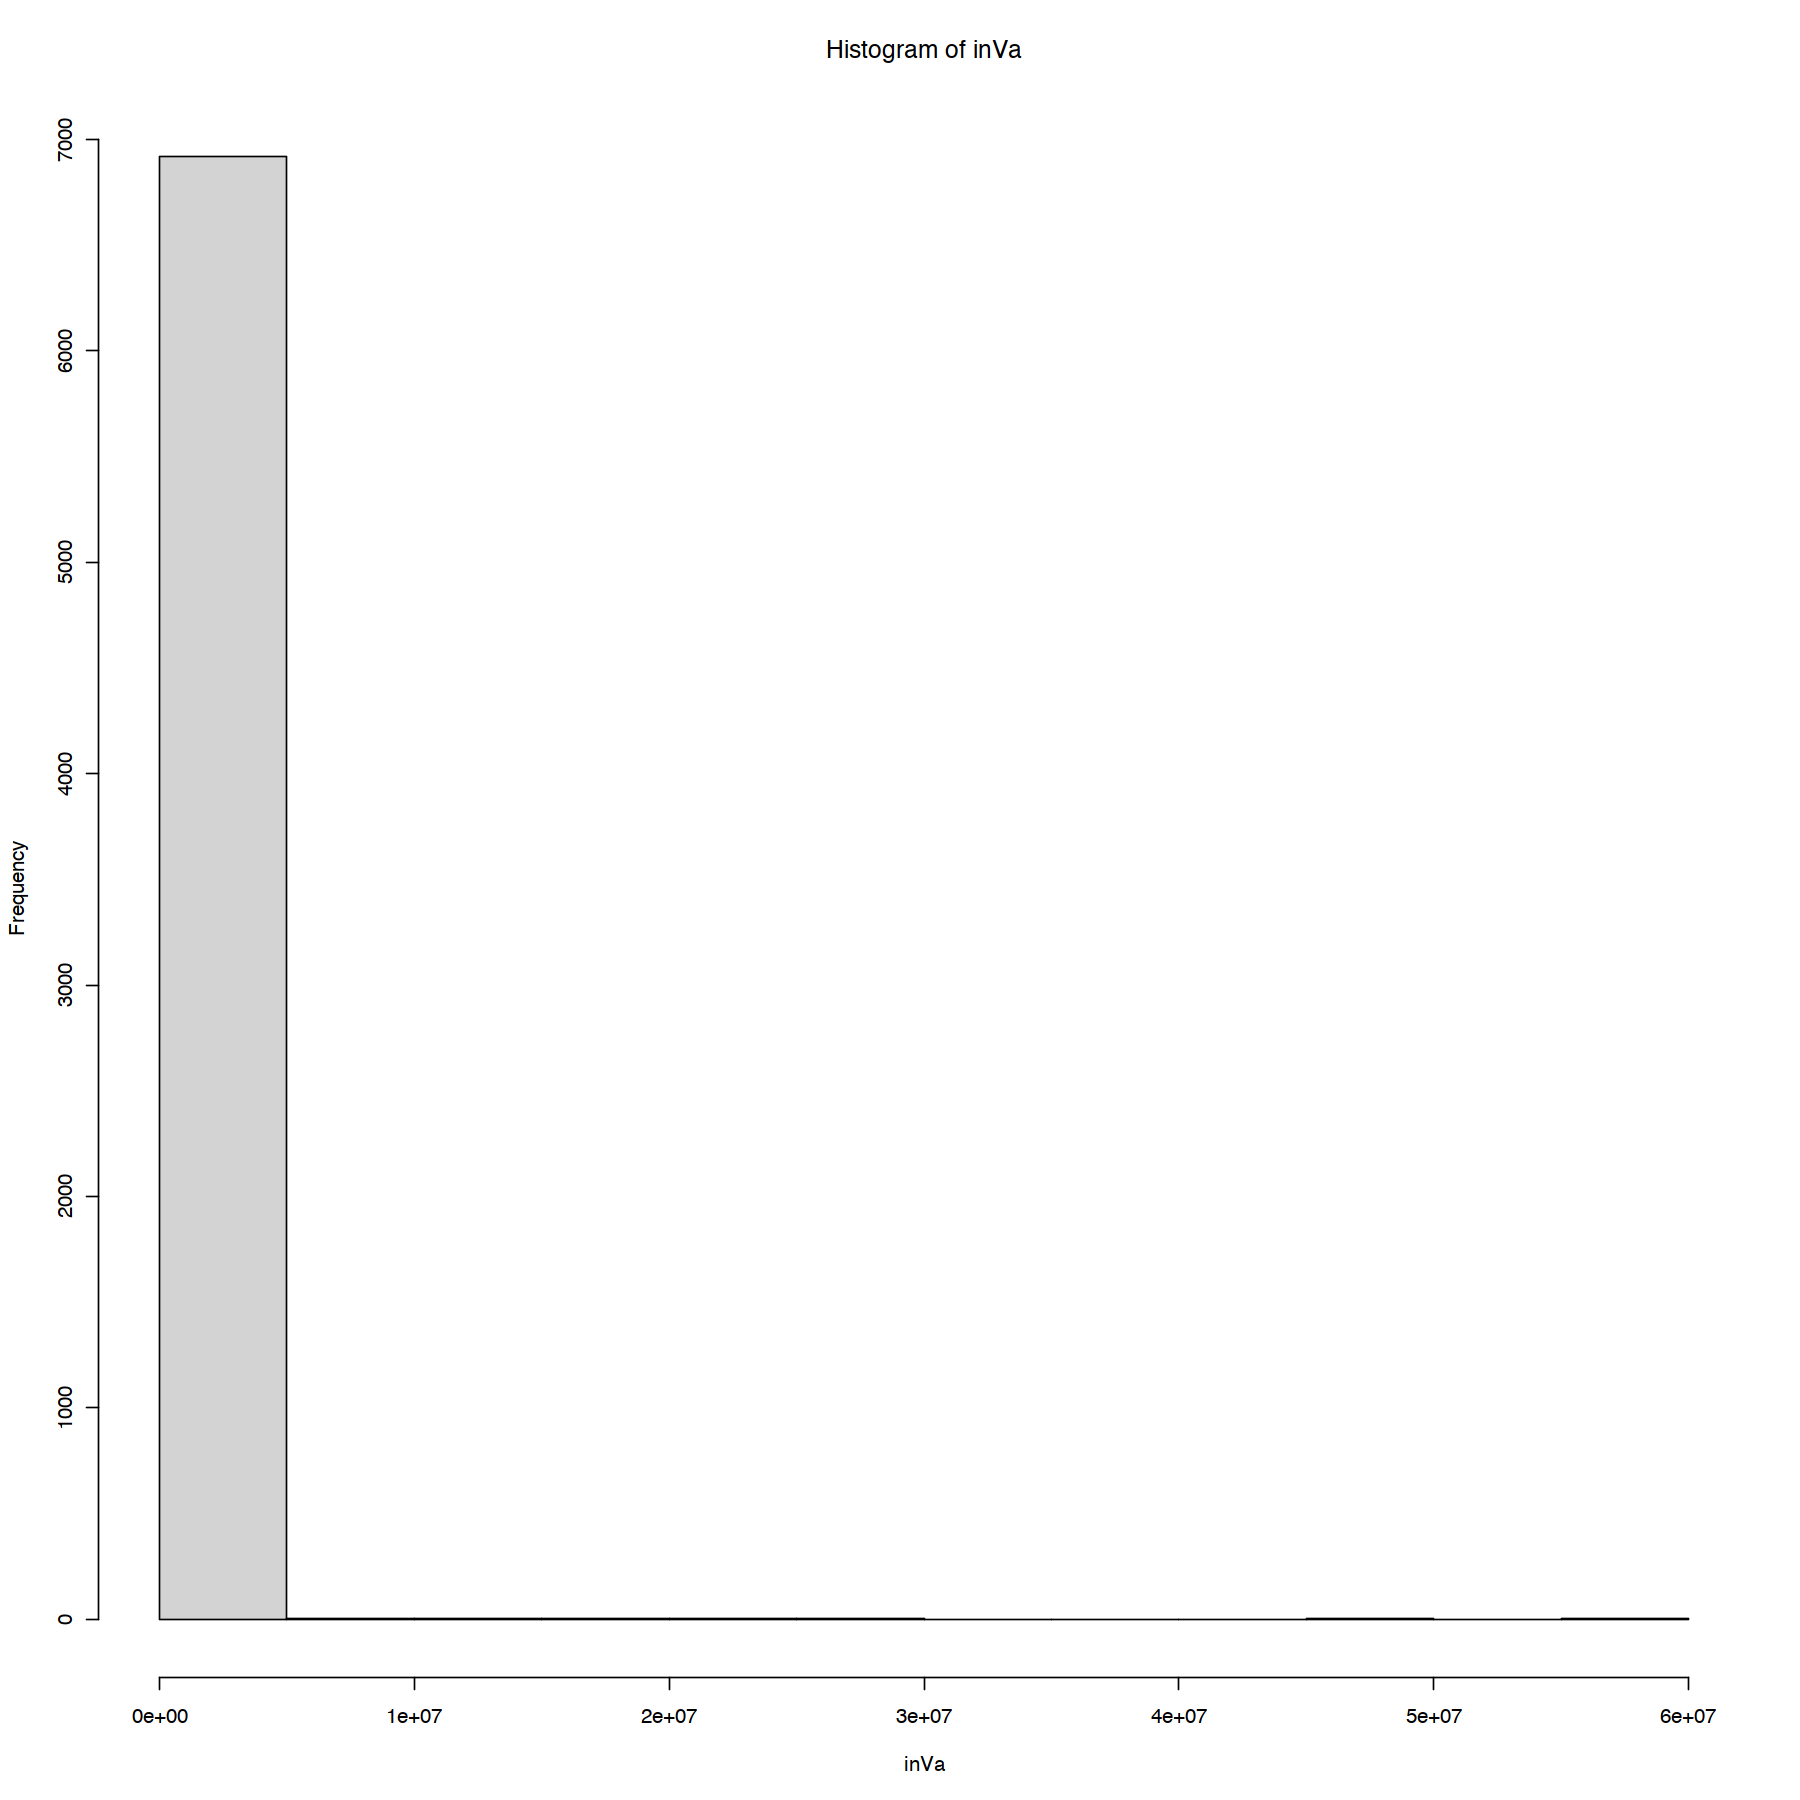

In [7]:
## Plot the density function.

hist(inVa)

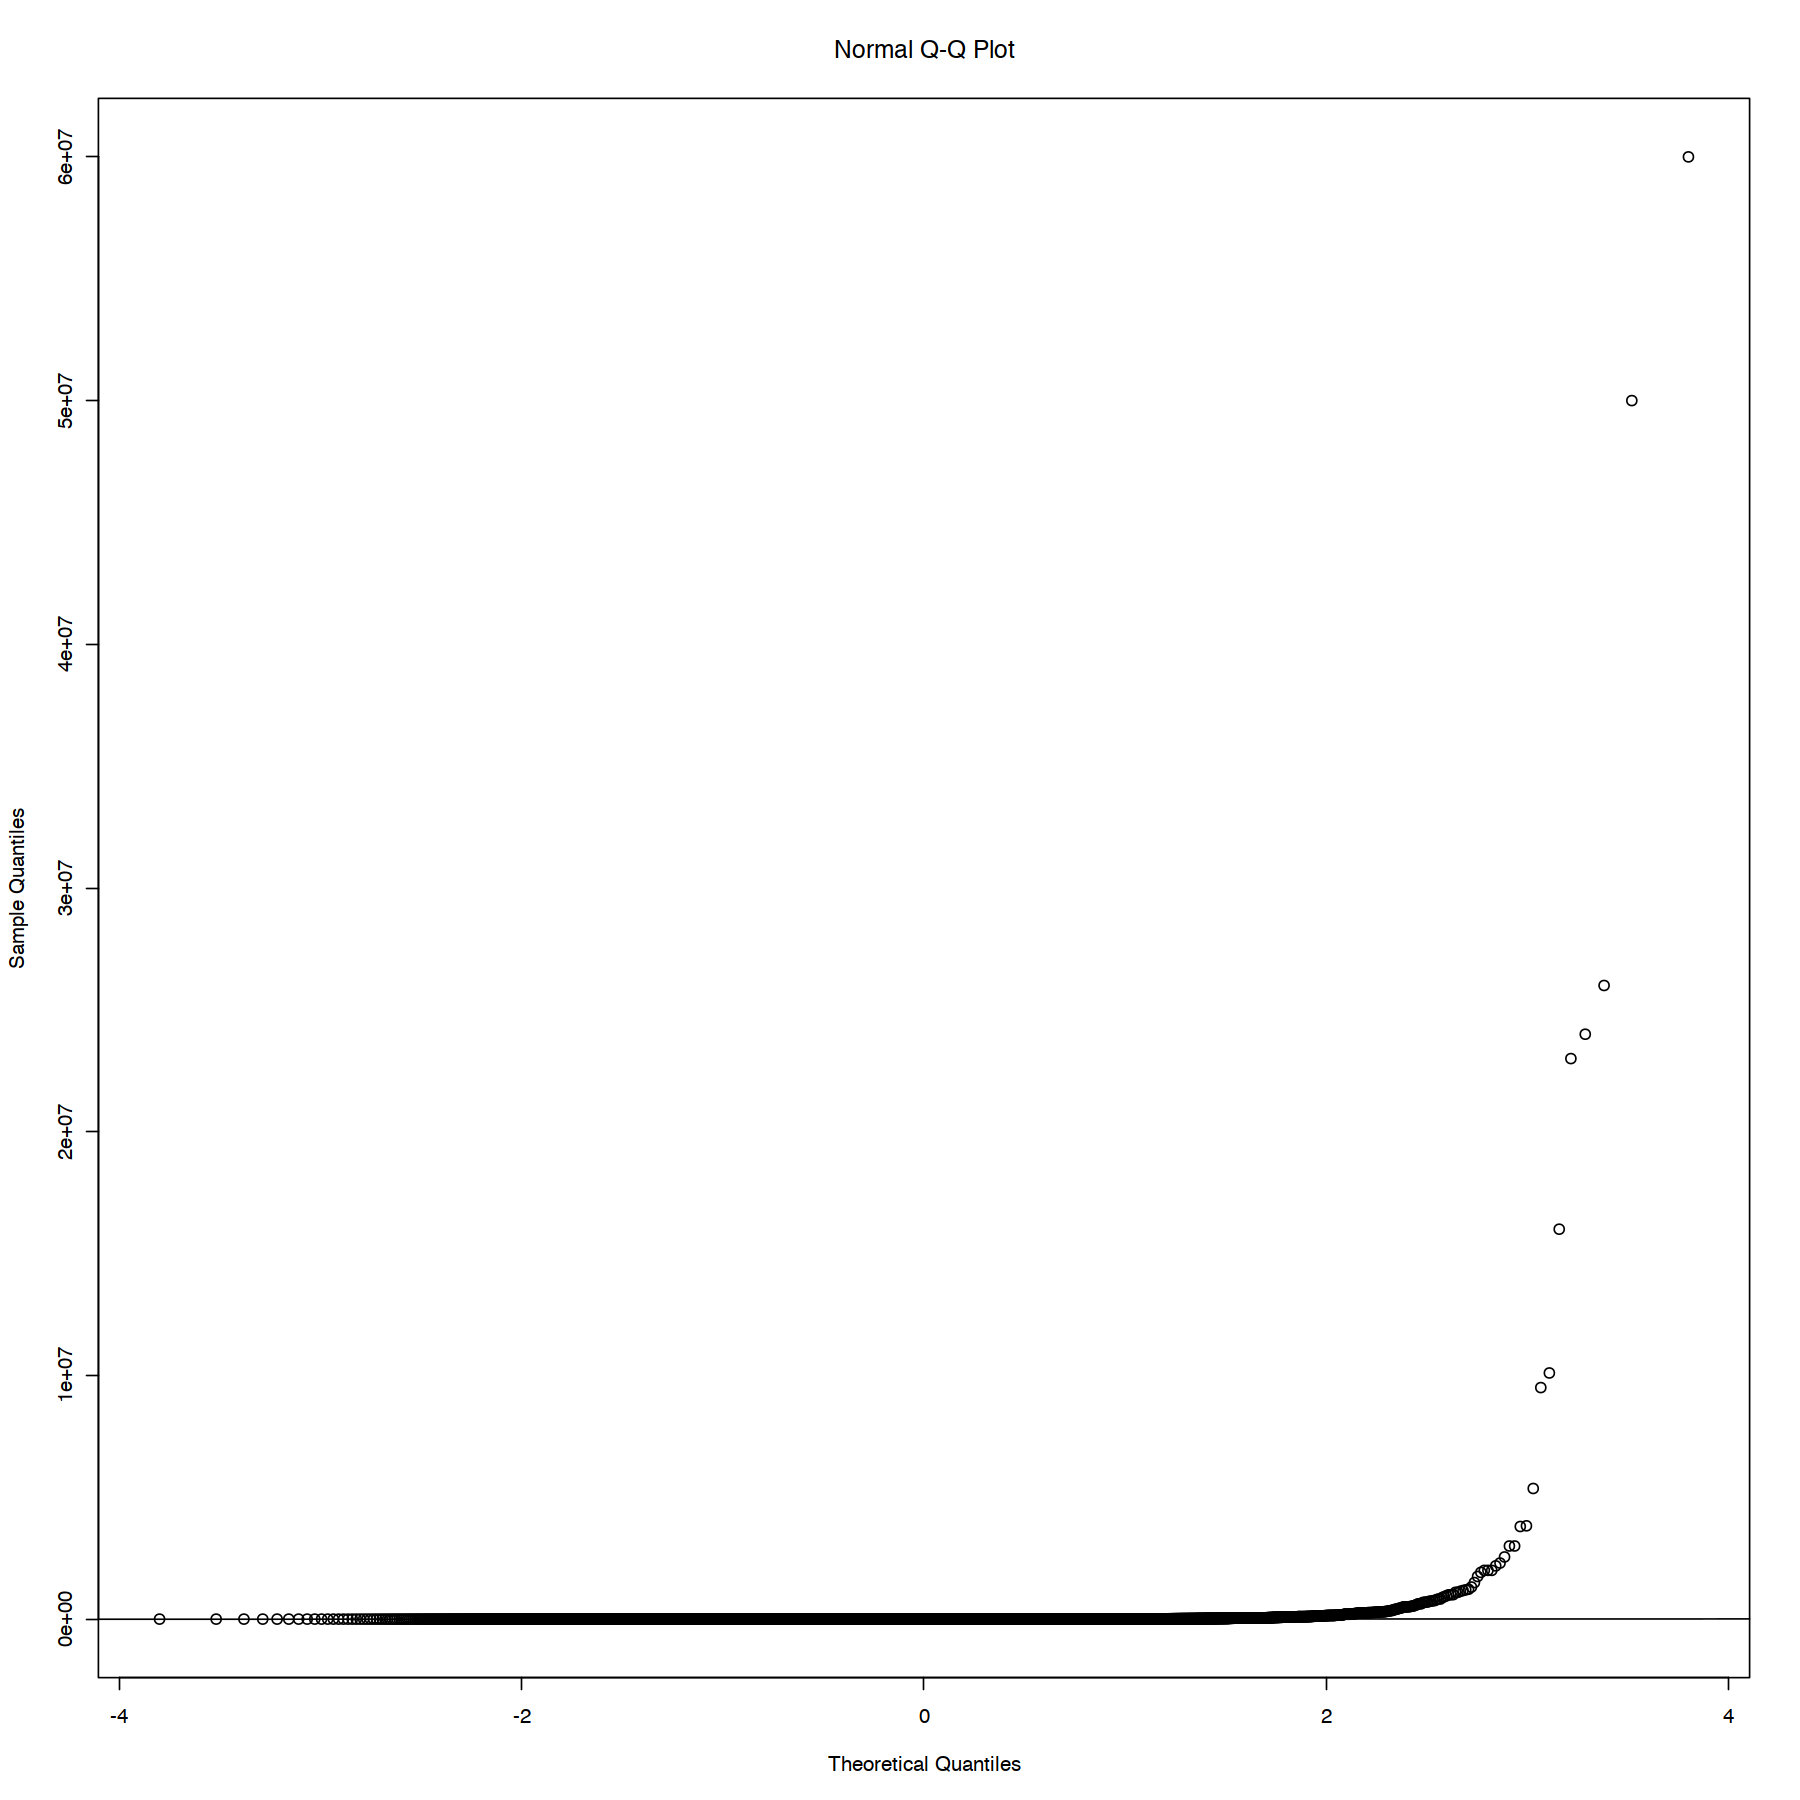

In [8]:
## Draw a qq plot.

qqnorm(inVa)

## Fit a line to the plot.

qqline(inVa)

In [9]:
shapiro.test(inVa)

ERROR: Error in shapiro.test(inVa): sample size must be between 3 and 5000


In [ ]:
## Estimate lambda value for Box-Cox transformation.

lambda <- BoxCox.lambda(inVa,method = "guerrero",lower=-4,upper=4) 
lambda

## Apply a Box-Cox transformation to a variable.

tva <- BoxCox(inVa,lambda)

## Test the transformed variable.

hist(tva)
shapiro.test(tva)

In [ ]:
longmin <- min(coordinates(train_ff)[,1])
longmax <- max(coordinates(train_ff)[,1])
latmin  <- min(coordinates(train_ff)[,2])
latmax  <- max(coordinates(train_ff)[,2])

## Create a grid object

cellsize <- 10000
grd <- expand.grid(Longitude = seq(from = longmin, to = longmax), Latitude = seq(from = latmin,to = latmax))

coordinates(grd) <- ~ Longitude + Latitude

gridded(grd) <- TRUE

proj4string(grd)=proj4string(train_f)

plot (grd,main="Interpolation Grid",cex.main=.8)
plot(train_f,border='blue',add=TRUE)

In [ ]:
cutoff <- 1000000
range <- 400000
sill <- 1000
nugget <- 2

## Create an empirical variogram.

vrg <- variogram(as.numeric (tva) ~ 1, train_f,cutoff=cutoff)

## Fit a mathematical model (exponential) to the empirical variogram.

fit.vrg.exp <- fit.variogram(vrg, vgm(psill=sill, "Exp", range=range, nugget=nugget))

## View the estimated variogram parameters.

fit.vrg.exp

## Plot fitted variogram.

plot(vrg,fit.vrg.exp)